# Homework 06: Support Vector Machine Classification
## Kerem Girenes
### April 28, 2022

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial.distance as dt
import scipy
#from qpsolvers import solve_qp
#import ecos
import cvxopt as cvx

## Importing Data

In [2]:
images = np.genfromtxt("hw06_data_set_images.csv", delimiter=",")
labels = np.genfromtxt("hw06_data_set_labels.csv", delimiter=",")

## Dividing the Data Set

In [3]:
X_train = images[:1000]
X_test = images[1000:]
y_train = labels[:1000].astype(int)
y_test = labels[1000:].astype(int)

# two distinct classes
K = 2

# N_train = N_test
N = X_train.shape[0]

# Pixel Count
PX = X_train.shape[1]

# Number of Bins
NO_BINS = 64

## Construct Color Histograms for Training and Test Data

In [4]:
bins = np.linspace(0, 1, NO_BINS)

H_train = np.zeros((N, NO_BINS))
H_test = np.zeros((N, NO_BINS))

for xi in range(N):
    for pi in range(PX):
        # train histogram
        b = (X_train[xi][pi]/4).astype(int)
        H_train[xi][b] += 1
        # test histogram
        b = (X_test[xi][pi]/4).astype(int)
        H_test[xi][b] += 1
    # normalize histograms
    H_train[xi] = H_train[xi] / PX
    H_test[xi] = H_test[xi] / PX
    
print(H_train[0:5, 0:5])
print(H_test[0:5, 0:5])

[[0.86479592 0.00127551 0.         0.00255102 0.        ]
 [0.66836735 0.         0.00127551 0.00127551 0.        ]
 [0.66454082 0.00637755 0.00382653 0.00765306 0.00892857]
 [0.65816327 0.00765306 0.00892857 0.00127551 0.00382653]
 [0.5625     0.00255102 0.00255102 0.00127551 0.        ]]
[[0.68239796 0.00255102 0.00127551 0.00127551 0.00127551]
 [0.69770408 0.01658163 0.00510204 0.00382653 0.01020408]
 [0.73341837 0.02678571 0.01530612 0.00510204 0.00637755]
 [0.63903061 0.00892857 0.00255102 0.00127551 0.        ]
 [0.75382653 0.00765306 0.00127551 0.00127551 0.        ]]


## Construct Kernel Matrices for Training and Test Data

In [5]:
def h_kernel(hi, hj):
    res = 0
    for l in range(NO_BINS):
        res += min(hi[l], hj[l])
    return res

K_train = np.zeros((N, N))
K_test = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        K_train[i][j] = h_kernel(H_train[i], H_train[j])
        K_test[i][j] = h_kernel(H_test[i], H_train[j])
        
print(K_train[0:5, 0:5])
print(K_test[0:5, 0:5])

[[1.         0.72321429 0.77040816 0.75382653 0.62755102]
 [0.72321429 1.         0.73086735 0.78571429 0.68622449]
 [0.77040816 0.73086735 1.         0.84056122 0.70153061]
 [0.75382653 0.78571429 0.84056122 1.         0.76403061]
 [0.62755102 0.68622449 0.70153061 0.76403061 1.        ]]
[[0.77806122 0.80867347 0.82142857 0.88647959 0.79209184]
 [0.79464286 0.76403061 0.84566327 0.86607143 0.77933673]
 [0.8380102  0.74362245 0.85714286 0.83035714 0.68877551]
 [0.71556122 0.84438776 0.75       0.83418367 0.75765306]
 [0.84438776 0.76785714 0.82397959 0.84183673 0.73469388]]


## Train a SVM Classifier and Calculate the Confusion Matrices

In [6]:
a = [np.array([[1.0001], [-1.0001]]), np.array([[-1.0001], [1.0001]])]
rounded = []

for array in a:
    for elt in array:
        rounded.append((round(elt[0])))
        
print(np.array(rounded))

[ 1. -1. -1.  1.]


In [11]:
# define Gaussian kernel function
def gaussian_kernel(X1, X2, s):
    D = dt.cdist(X1, X2)
    K = np.exp(-D**2 / (2 * s**2))
    return(K)

def train_svm(X_set, y_set, N, s, C, epsilon):
    # calculate Gaussian kernel
    K_set = gaussian_kernel(X_set, X_set, s)
    yyK = np.matmul(y_set[:,None], y_set[None,:]) * K_set

    P = cvx.matrix(yyK)
    q = cvx.matrix(-np.ones((N, 1)))
    G = cvx.matrix(np.vstack((-np.eye(N), np.eye(N))))
    h = cvx.matrix(np.vstack((np.zeros((N, 1)), C * np.ones((N, 1)))))
    A = cvx.matrix(1.0 * y_set[None,:])
    b = cvx.matrix(0.0)

    # use cvxopt library to solve QP problems
    result = cvx.solvers.qp(P, q, G, h, A, b)
    alpha = np.reshape(result["x"], N)
    alpha[alpha < C * epsilon] = 0
    alpha[alpha > C * (1 - epsilon)] = C

    # find bias parameter
    support_indices, = np.where(alpha != 0)
    active_indices, = np.where(np.logical_and(alpha != 0, alpha < C))
    w0 = np.mean(y_set[active_indices] * (1 - np.matmul(yyK[np.ix_(active_indices, support_indices)], alpha[support_indices])))
    
    return alpha, w0

def pred(K_train, K_test, s, C, epsilon):
    f_pred_train = []
    f_pred_test = []
    y_set = np.zeros((N))
    alpha, w0 = train_svm(X_train, y_set, N, s, C, epsilon)
    # training predictions
    f_pred_train = np.matmul(K_train, y_set[:, None] * alpha[:, None]) + w0
    # test predictions
    f_pred_test = np.matmul(K_test, y_set[:, None] * alpha[:, None]) + w0
    # prediction labels
    y_pred_train = []
    y_pred_test = []
    
    y_pred_train = 2 * (f_predicted > 0.0) - 1
    y_pred_test = 2 * (f_predicted > 0.0) - 1
    
    return y_pred_train, y_pred_test   

C = 10
s = 10
epsilon = 0.001

K_train = gaussian_kernel(X_train, X_train, s)
K_test = gaussian_kernel(X_test, X_train, s)

y_pred_train, y_pred_test = pred(K_train, K_test, s, C, epsilon)

print(pd.crosstab(y_pred_train, y_train, rownames=['y_predicted'], colnames=['y_train']))
print(pd.crosstab(y_pred_test, y_test, rownames=['y_predicted'], colnames=['y_test']))

ValueError: Rank(A) < p or Rank([P; A; G]) < n

## Train SVM by Varying C, Plot Accuracies

     pcost       dcost       gap    pres   dres
 0: -2.9939e+02 -2.3105e+02  3e+03  2e+01  3e-16
 1: -9.9499e+01 -1.8049e+02  1e+02  2e-01  2e-16
 2: -9.2247e+01 -9.7944e+01  6e+00  1e-15  2e-16
 3: -9.3723e+01 -9.4382e+01  7e-01  1e-15  4e-16
 4: -9.3738e+01 -9.3745e+01  7e-03  4e-15  6e-16
 5: -9.3738e+01 -9.3738e+01  7e-05  2e-15  6e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.4243e+02 -5.9186e+02  3e+03  5e+00  2e-16
 1: -2.2268e+02 -4.8646e+02  3e+02  9e-15  8e-17
 2: -2.5205e+02 -2.6829e+02  2e+01  4e-14  2e-16
 3: -2.6307e+02 -2.6519e+02  2e+00  2e-14  1e-16
 4: -2.6315e+02 -2.6322e+02  7e-02  4e-15  5e-16
 5: -2.6318e+02 -2.6318e+02  7e-04  2e-14  2e-16
 6: -2.6318e+02 -2.6318e+02  7e-06  1e-14  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.4436e+02 -1.5647e+03  1e+03  1e-13  5e-16
 1: -4.6900e+02 -5.4080e+02  7e+01  3e-14  3e-16
 2: -4.9522e+02 -5.0542e+02  1e+01  2e-14  8e-17
 3: -4.9917e+02 -5.0053e

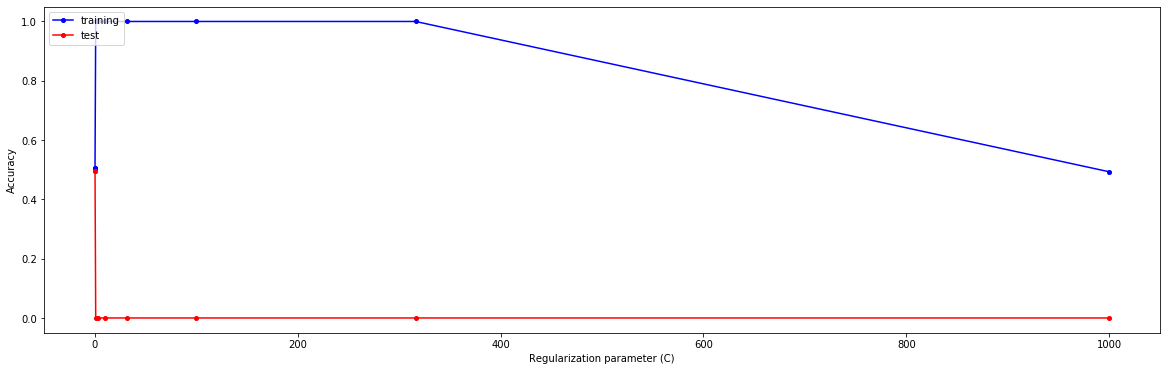

In [8]:
C = [10**-1, 10**-.5, 10**0, 10**.5, 10**1, 10**1.5, 10**2, 10**2.5, 10**3]

training_scores = []
test_scores = []

def accuracy(y_pred, y_truth):
    score = 0.0
    for i in range(len(y_truth)):
        score += (y_pred[i] == y_truth[i]) * 1.0
    return score / len(y_truth)

for c in C:
    y_pred_train, y_pred_test = pred(K_train, K_test, s, c, epsilon)
    training_scores.append(accuracy(y_pred_train, y_train))
    test_scores.append(accuracy(y_pred_test, y_test))
    
plt.figure(figsize=(20,6))
plt.plot(C, training_scores, "-ob", markersize=4, label='training')
plt.plot(C, test_scores, "-or", markersize=4, label='test')
plt.xlabel("Regularization parameter (C)")
plt.ylabel("Accuracy")
plt.legend(loc='upper left')
plt.show()